## NEURAL NET METHOD IMPLEMENTATION

In [1]:
import torch

In [2]:
if torch.backends.mps.is_built():
    print("PyTorch is built with MPS")
else:
    print("MPS not available.")


PyTorch is built with MPS


In [3]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
else:
    print("MPS device not found") 

In [4]:
#torch.set_default_device('mps')

mod = torch.nn.Linear(20,30)
print(mod.weight.device)
print(mod(torch.randn(128, 20)).device)

cpu
cpu


In [5]:
import sys
sys.version

'3.9.12 (main, Apr  5 2022, 01:53:17) \n[Clang 12.0.0 ]'

In [6]:
import platform
platform.architecture()


('64bit', '')

## PRE-PROCESSING

In [1]:
# Basic utilities
import os
import platform
import re

# Data handling and manipulation
import numpy as np
import pandas as pd
import ast

# Text preprocessing and sentiment analysis utilities
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from bs4 import BeautifulSoup
import contractions

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn utilities for model evaluation, data splitting, and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, f1_score, recall_score, 
                             precision_score, confusion_matrix, classification_report)

# Other utilities and models
import fasttext

In [8]:
def general_info():
    print("Machine:", platform.machine())
    print("Platform:", platform.platform())
    print("Mac Version:", platform.mac_ver())
    print("Processor:", platform.processor())
    print("Python Version:", platform.python_version())
  
general_info()

Machine: x86_64
Platform: macOS-10.16-x86_64-i386-64bit
Mac Version: ('10.16', ('', '', ''), 'x86_64')
Processor: i386
Python Version: 3.9.12


In [9]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 8.2.0
ipykernel        : 6.9.1
ipywidgets       : 7.6.5
jupyter_client   : 6.1.12
jupyter_core     : 4.9.2
jupyter_server   : 1.13.5
jupyterlab       : 3.3.2
nbclient         : 0.5.13
nbconvert        : 6.4.4
nbformat         : 5.3.0
notebook         : 6.4.8
qtconsole        : 5.3.0
traitlets        : 5.1.1


In [10]:
# Specify the path to the dataset, load the csv into Pandas DataFrame
data_pth = '/users/anshulvij/Desktop/Masters Project Code/Tweets.csv'
df = pd.read_csv(data_pth)
df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [11]:
def display_sentiment_counts(dataframe, column_name='sentiment'):
    """
    Display the counts and percentages of unique values in the specified column.
    
    Args:
    - dataframe (pd.DataFrame): The dataframe containing the data.
    - column_name (str): The name of the column to compute the statistics for. Default is 'sentiment'.
    
    Returns:
    - None
    """
    sentiment_counts = dataframe[column_name].value_counts()
    print("\nCount of each sentiment:")
    print(sentiment_counts)

    sentiment_percentages = dataframe[column_name].value_counts(normalize=True)*100
    print(sentiment_percentages)

display_sentiment_counts(df)


Count of each sentiment:
neutral     11118
positive     8582
negative     7781
Name: sentiment, dtype: int64
neutral     40.457043
positive    31.228849
negative    28.314108
Name: sentiment, dtype: float64


In [12]:
def check_missing_data(dataframe):
    """
    Check for missing data in the dataframe.
    
    Args:
    - dataframe (pd.DataFrame): The dataframe to inspect.
    
    Returns:
    - pd.Series: A series containing counts of missing data for each column.
    """
    return dataframe.isnull().sum()

# Display the number of missing values for each column
print("Missing Values:\n", check_missing_data(df))

# Remove rows with missing values
df.dropna(inplace=True)
print(f"Post Filtering Step-1: Total Rows - {len(df)}")

Missing Values:
 textID           0
text             1
selected_text    1
sentiment        0
dtype: int64
Post Filtering Step-1: Total Rows - 27480


In [13]:
def custom_handle_contractions(text):
    """
    Expand contractions in the provided text using a predefined contractions dictionary.
    This function handles contractions formed both with standard apostrophes and backticks.
    
    Args:
    - text (str): The input text containing contractions.
    
    Returns:
    - str: The input text with all recognized contractions expanded.
    
    """
    
    # Define a dictionary of contractions and their expanded forms
    contractions_dict = contractions.contractions_dict
    
    # Replace the contractions with their expanded form
    for contraction, expansion in contractions_dict.items():
        # Handle both apostrophes and backticks
        text = text.replace(contraction, expansion)
        text = text.replace(contraction.replace("'", "`"), expansion)

    return text

# Applying it to the DataFrame
df['text'] = df['text'].apply(custom_handle_contractions)


In [14]:
df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I would have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why could not they put them on ...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I have wondered about rake to. The client ha...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [15]:
def clean_text(text):
    """
    Clean the provided text by removing URLs, mentions, numbers, hashtags, non-ASCII characters, and converting to lowercase.
    
    Args:
    - text (str): The input text.
    
    Returns:
    - str: The cleaned text.
    """
    text = text.lower() 
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'#\S+', '', text)  # Remove hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Remove non-ASCII characters
    return text

df['cleaned_tweets'] = df['text'].apply(clean_text)


In [16]:
def retain_required_columns(df, required_columns):
    """
    Retains only the specified required columns in the DataFrame and drops all others.
    
    Args:
    - df (pd.DataFrame): The input DataFrame.
    - required_columns (list): List of column names to retain.
    
    Returns:
    - pd.DataFrame: DataFrame containing only the required columns.
    """
    
    # Check if required columns are present in the dataframe
    missing_columns = [col for col in required_columns if col not in df.columns]
    
    if missing_columns:
        raise ValueError(f"The following required columns are not present in the DataFrame: {missing_columns}")
    
    return df[required_columns]


df = retain_required_columns(df, ['sentiment', 'cleaned_tweets'])

In [17]:
df

,sentiment,cleaned_tweets
0,neutral,i would have responded if i were going
1,negative,sooo sad i will miss you here in san diego
2,negative,my boss is bullying me
3,negative,what interview leave me alone
4,negative,sons of why could not they put them on the r...
...,...,...
27476,negative,wish we could come see u on denver husband l...
27477,negative,i have wondered about rake to the client has...
27478,positive,yay good for both of you enjoy the break you...
27479,positive,but it was worth it


In [18]:
# Detect all duplicates based on the 'cleaned_text' column
duplicates_mask = df.duplicated(subset='cleaned_tweets', keep=False)

# Remove all rows with duplicate 'cleaned_text'
df = df[~duplicates_mask]

In [19]:
df

,sentiment,cleaned_tweets
0,neutral,i would have responded if i were going
1,negative,sooo sad i will miss you here in san diego
2,negative,my boss is bullying me
3,negative,what interview leave me alone
4,negative,sons of why could not they put them on the r...
...,...,...
27476,negative,wish we could come see u on denver husband l...
27477,negative,i have wondered about rake to the client has...
27478,positive,yay good for both of you enjoy the break you...
27479,positive,but it was worth it


In [20]:
def display_sentiment_counts(dataframe, column_name='sentiment'):
    """
    Display the counts and percentages of unique values in the specified column.
    
    Args:
    - dataframe (pd.DataFrame): The dataframe containing the data.
    - column_name (str): The name of the column to compute the statistics for. Default is 'sentiment'.
    
    Returns:
    - None
    """
    sentiment_counts = dataframe[column_name].value_counts()
    print("\nCount of each sentiment:")
    print(sentiment_counts)

    sentiment_percentages = dataframe[column_name].value_counts(normalize=True)*100
    print(sentiment_percentages)

display_sentiment_counts(df)


Count of each sentiment:
neutral     11030
positive     8435
negative     7735
Name: sentiment, dtype: int64
neutral     40.551471
positive    31.011029
negative    28.437500
Name: sentiment, dtype: float64


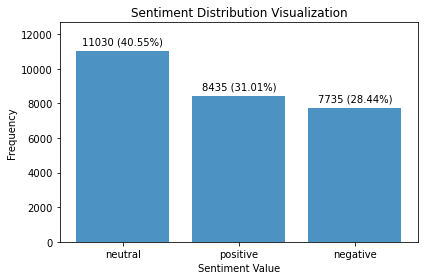

In [21]:
import matplotlib.pyplot as plt

# Calculate sentiment frequency and its relative percentage
sentiment_frequency = df['sentiment'].value_counts()
sentiment_ratio = df['sentiment'].value_counts(normalize=True) * 100

# Display sentiment distribution using a bar chart
bars = plt.bar(sentiment_frequency.index, sentiment_frequency.values, alpha=0.8)

# Adjust the y-axis limit
plt.ylim(0, max(sentiment_frequency.values) * 1.15)  # Increase the upper limit by 15% of the highest bar value

# Label each bar with the sentiment count and its percentage
for idx, bar in enumerate(bars):
    yval = bar.get_height()
    sentiment_label = sentiment_frequency.index[idx]
    plt.text(bar.get_x() + bar.get_width()/2, yval + max(sentiment_frequency.values) * 0.05, 
             f'{int(yval)} ({sentiment_ratio[sentiment_label]:.2f}%)',
             ha='center', va='center')

plt.xlabel('Sentiment Value')
plt.ylabel('Frequency')
plt.title('Sentiment Distribution Visualization')
plt.tight_layout()
plt.show()

FASTText Implementation

In [22]:
def fasttext_format(df):
    """
    Converts the sentiment column to the '__label__' format that FastText requires.
    
    Parameters:
    - df (DataFrame): Dataframe with the 'Sentiment' column to be converted.
    
    Returns:
    DataFrame: Dataframe with modified 'Sentiment' column.
    """
    df['sentiment'] = '__label__' + df['sentiment'].astype(str)
    return df

In [23]:
def save_to_txt(dataframes, filenames):
    """
    Save dataframes to txt format.
    
    Parameters:
    - dataframes (list): List of dataframes to be saved.
    - filenames (list): List of filenames to save the dataframes as.
    
    Returns:
    None
    """
    for subset, name in zip(dataframes, filenames):
        subset[['cleaned_tweets', 'sentiment']].to_csv(f'{name}.txt', index=False, sep=' ', header=None)


In [24]:
def fasttext_hyperparameter_autotune(train_file, val_file, duration):
    """
    Train FastText supervised model with autotuning on given train and validation files.
    
    Parameters:
    - train_file (str): Path to the training dataset.
    - val_file (str): Path to the validation dataset.
    - duration (int): Duration in seconds for the autotune process.
    
    Returns:
    FastText model
    """
    return fasttext.train_supervised(
        input=train_file,
        autotuneValidationFile=val_file,
        autotuneDuration=duration
    )

In [25]:
def display_report(data_df, model, set_name="Data"):
    """
    Evaluate a FastText model on the given data.
    
    Parameters:
    - data_df (DataFrame): Data to be evaluated on.
    - model (FastText model): Model for evaluation.
    - set_name (str, optional): Name for the data set being evaluated.
    
    Returns:
    None
    """
    labels = data_df['sentiment'].str.replace('__label__', '').tolist()
    sentences = data_df['cleaned_tweets'].tolist()
    preds = [model.predict(x)[0][0].replace('__label__', '') for x in sentences]

    # Printing classification report
    report = classification_report(labels, preds, labels=["positive", "negative", "neutral"], digits =4)
    print(f'{set_name} Classification Report:\n')
    print(report)

    # Plotting the confusion matrix
    conf_mat = confusion_matrix(labels, preds, labels=["positive", "negative", "neutral"])
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'{set_name} Confusion matrix')
    plt.show()
    

In [5]:
def compute_FPR_spec_metrics(cm, labels=["positive", "negative", "neutral"]):
    """
    Compute specificity, FPR, precision for each class, and the overall accuracy given a 3x3 confusion matrix.
    Also, computes weighted and macro average for FPR and specificity.

    Args:
    - cm (numpy array): 3x3 confusion matrix
    - labels (list): List of class labels in order

    Returns:
    None. It will print the results directly.
    """
    
    specificities = []
    fprs = []
    precisions = []

    for i in range(3):
        tp = cm[i, i]
        tn = sum(cm[j, j] for j in range(3) if j != i)
        fp = sum(cm[j, i] for j in range(3) if j != i)
        fn = sum(cm[i, j] for j in range(3) if j != i)
        
        specificity = tn / (tn + fp) if tn + fp != 0 else 0
        fpr = 1 - specificity
        precision = tp / (tp + fp) if tp + fp != 0 else 0
        
        specificities.append(round(specificity, 4))
        fprs.append(round(fpr, 4))
        precisions.append(round(precision, 4))
    
    # Print the class values with their corresponding metrics
    for i, label in enumerate(labels):
        print(f"Metrics for class {label} (Class value: {i}):")
        print(f"Specificity: {specificities[i]}")
        print(f"FPR: {fprs[i]}")
        print(f"Precision: {precisions[i]}\n")

    # Calculate overall accuracy
    accuracy = round(np.trace(cm) / np.sum(cm), 4)
    print(f"Overall accuracy: {accuracy}")

    # Calculate true values for each class for weighting purposes
    true_values = np.sum(cm, axis=1)
    total_true_values = np.sum(true_values)

    # Calculate weighted average specificity and FPR
    weighted_avg_spec = round(sum(specificities[i] * true_values[i] for i in range(3)) / total_true_values, 4)
    weighted_avg_fpr = round(sum(fprs[i] * true_values[i] for i in range(3)) / total_true_values, 4)

    # Calculate macro average specificity and FPR
    macro_avg_spec = round(np.mean(specificities), 4)
    macro_avg_fpr = round(np.mean(fprs), 4)

    print(f"Weighted average specificity: {weighted_avg_spec}")
    print(f"Weighted average FPR: {weighted_avg_fpr}")
    print(f"Macro average specificity: {macro_avg_spec}")
    print(f"Macro average FPR: {macro_avg_fpr}\n")


In [35]:
def display_sentences(data_df, model):
    """
    Print the sentences that were misclassified by the model.
    
    Parameters:
    - data_df (DataFrame): Data with actual labels and sentences.
    - model (FastText model): Model used for predictions.
    
    Returns:
    None
    """
    labels = data_df['sentiment'].str.replace('__label__', '').tolist()
    sentences = data_df['cleaned_tweets'].tolist()
    preds = [model.predict(x)[0][0].replace('__label__', '') for x in sentences]

    print("\nMisclassified Sentences:\n")
    for actual, pred, sent in zip(labels, preds, sentences):
        if actual != pred:
            print(f"Actual: {actual}, Predicted: {pred}, Tweets: {sent}")


In [27]:
# Converting to FastText format
df = fasttext_format(df)

# Splitting the dataset into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=5)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=5)

# Saving datasets to txt format
save_to_txt([train_df, val_df, test_df], ['train', 'val', 'test'])

/var/folders/_4/gqsgcp1j0kx8p_ctzh3ddsmm0000gn/T/ipykernel_739/3056166140.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = '__label__' + df['sentiment'].astype(str)


Progress: 100.0% Trials:  954 Best score:  0.711275 ETA:   0h 0m 0s
Training again with best arguments
Read 0M words
Number of words:  26226
Number of labels: 3
Progress: 100.0% words/sec/thread:  863249 lr:  0.000000 avg.loss:  0.653850 ETA:   0h 0m 0s


Evaluating with obtained hyperparameters: <fasttext_pybind.args object at 0x7f94b4630bf0>
Validation Classification Report:

              precision    recall  f1-score   support

    positive     0.7761    0.7408    0.7581      1254
    negative     0.6992    0.6626    0.6804      1147
     neutral     0.6643    0.7105    0.6866      1679

    accuracy                         0.7064      4080
   macro avg     0.7132    0.7047    0.7084      4080
weighted avg     0.7084    0.7064    0.7068      4080



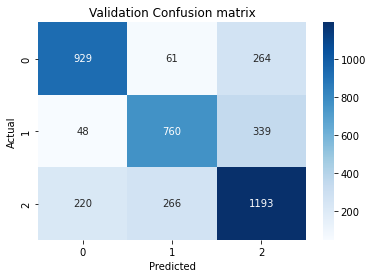

Test Classification Report:

              precision    recall  f1-score   support

    positive     0.7676    0.7415    0.7543      1265
    negative     0.7182    0.6616    0.6888      1194
     neutral     0.6496    0.7045    0.6759      1621

    accuracy                         0.7034      4080
   macro avg     0.7118    0.7025    0.7063      4080
weighted avg     0.7063    0.7034    0.7040      4080



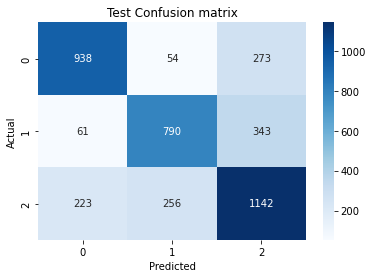

In [28]:
# Train with autotune
model = fasttext_hyperparameter_autotune('train.txt', 'val.txt', 1200)
hyperparameters = model.f.getArgs()
print(f"Evaluating with obtained hyperparameters: {hyperparameters}")

display_report(val_df, model, "Validation")
display_report(test_df, model, "Test")

In [6]:
cm = np.array([[938, 54, 273], 
               [61, 790, 343], 
               [223, 256, 1142]])

compute_FPR_spec_metrics(cm)

Metrics for class positive (Class value: 0):
Specificity: 0.8718
FPR: 0.1282
Precision: 0.7676

Metrics for class negative (Class value: 1):
Specificity: 0.8703
FPR: 0.1297
Precision: 0.7182

Metrics for class neutral (Class value: 2):
Specificity: 0.7372
FPR: 0.2628
Precision: 0.6496

Overall accuracy: 0.7034
Weighted average specificity: 0.8179
Weighted average FPR: 0.1821
Macro average specificity: 0.8264
Macro average FPR: 0.1736



In [29]:
print("The hyperparameters after autotuning:-")
print("Learning rate:", hyperparameters.lr)
print("Dimension:", hyperparameters.dim)
print("Epoch:", hyperparameters.epoch)

The hyperparameters after autotuning:-
Learning rate: 0.11136168856188972
Dimension: 60
Epoch: 11


In [36]:
# Print misclassified sentences
display_sentences(val_df, model)
display_sentences(test_df, model)


Misclassified Sentences:

Actual: positive, Predicted: neutral, Tweets: kewl the jb chat was awesome i had to miss lots of it though cause i had  go  skewl
Actual: neutral, Predicted: negative, Tweets: omgdid i just see a tweet from miss bonnie amazingmy phone died yesterdayand oster has alltel  i miss you
Actual: neutral, Predicted: negative, Tweets: is hittin the ole dusty trail w miss morgan
Actual: neutral, Predicted: negative, Tweets:  no problem unfortunately i think it was just something i had to sort out on my own
Actual: neutral, Predicted: negative, Tweets:  aww poor caity  l add people n they will add you
Actual: negative, Predicted: neutral, Tweets: just potted some geraniums then talked to the grandkids well maddie  jack was outside playing  i sure miss them
Actual: negative, Predicted: positive, Tweets: want to b marie antoinette cos she had perfect hairdo fab clothes n tons of macarons  crappy day
Actual: neutral, Predicted: negative, Tweets: my mom just texted me and t

In [31]:
model.save_model("model_fasttext.bin")

In [32]:
print(model.words)
print(model.labels)

['</s>', '"', 'i', 'to', 'the', 'a', 'my', 'and', 'is', 'you', 'it', 'not', 'for', 'in', 'of', 'have', 'that', 'on', 'am', 'so', 'me', 'but', 'with', 'was', 'be', 'are', 'do', '"i', 'at', 'just', 'day', 'will', 'all', 'get', 'this', 'like', 'going', 'out', 'up', 'good', 'no', 'go', 'im', 'now', 'your', 'got', 'love', 'its', 'from', 'want', 'work', 'we', 'what', 'one', 'know', 'too', 'u', 'really', 'can', 'see', 'about', 'today', 'some', 'back', 'if', 'time', 'did', 'had', 'there', 'they', 'as', 'think', 'new', 'would', 'how', 'when', 'cannot', 'more', 'an', 'mothers', 'still', 'night', 'miss', 'lol', 'well', 'he', 'great', 'much', 'happy', 'home', 'oh', 'hope', 'need', 'here', 'feel', 'thanks', 'she', 'has', 'off', 'it"', '"is', 'been', 'last', 'me"', 'her', '"just', 'or', 'could', 'wish', 'only', 'then', 'make', 'by', 'you"', 'dont', 'very', 'should', 'morning', 'twitter', 'day"', 'sorry', 'haha', 'fun', 'right', 'nice', 'yeah', 'bad', 'better', 'why', 'them', '"my', 'way', 'were', 'o

In [33]:
model = fasttext.load_model("model_fasttext.bin")

In [34]:
print(model.words)

['</s>', '"', 'i', 'to', 'the', 'a', 'my', 'and', 'is', 'you', 'it', 'not', 'for', 'in', 'of', 'have', 'that', 'on', 'am', 'so', 'me', 'but', 'with', 'was', 'be', 'are', 'do', '"i', 'at', 'just', 'day', 'will', 'all', 'get', 'this', 'like', 'going', 'out', 'up', 'good', 'no', 'go', 'im', 'now', 'your', 'got', 'love', 'its', 'from', 'want', 'work', 'we', 'what', 'one', 'know', 'too', 'u', 'really', 'can', 'see', 'about', 'today', 'some', 'back', 'if', 'time', 'did', 'had', 'there', 'they', 'as', 'think', 'new', 'would', 'how', 'when', 'cannot', 'more', 'an', 'mothers', 'still', 'night', 'miss', 'lol', 'well', 'he', 'great', 'much', 'happy', 'home', 'oh', 'hope', 'need', 'here', 'feel', 'thanks', 'she', 'has', 'off', 'it"', '"is', 'been', 'last', 'me"', 'her', '"just', 'or', 'could', 'wish', 'only', 'then', 'make', 'by', 'you"', 'dont', 'very', 'should', 'morning', 'twitter', 'day"', 'sorry', 'haha', 'fun', 'right', 'nice', 'yeah', 'bad', 'better', 'why', 'them', '"my', 'way', 'were', 'o